Generating Lorenz attractor observations...
Running predictive coding inference...


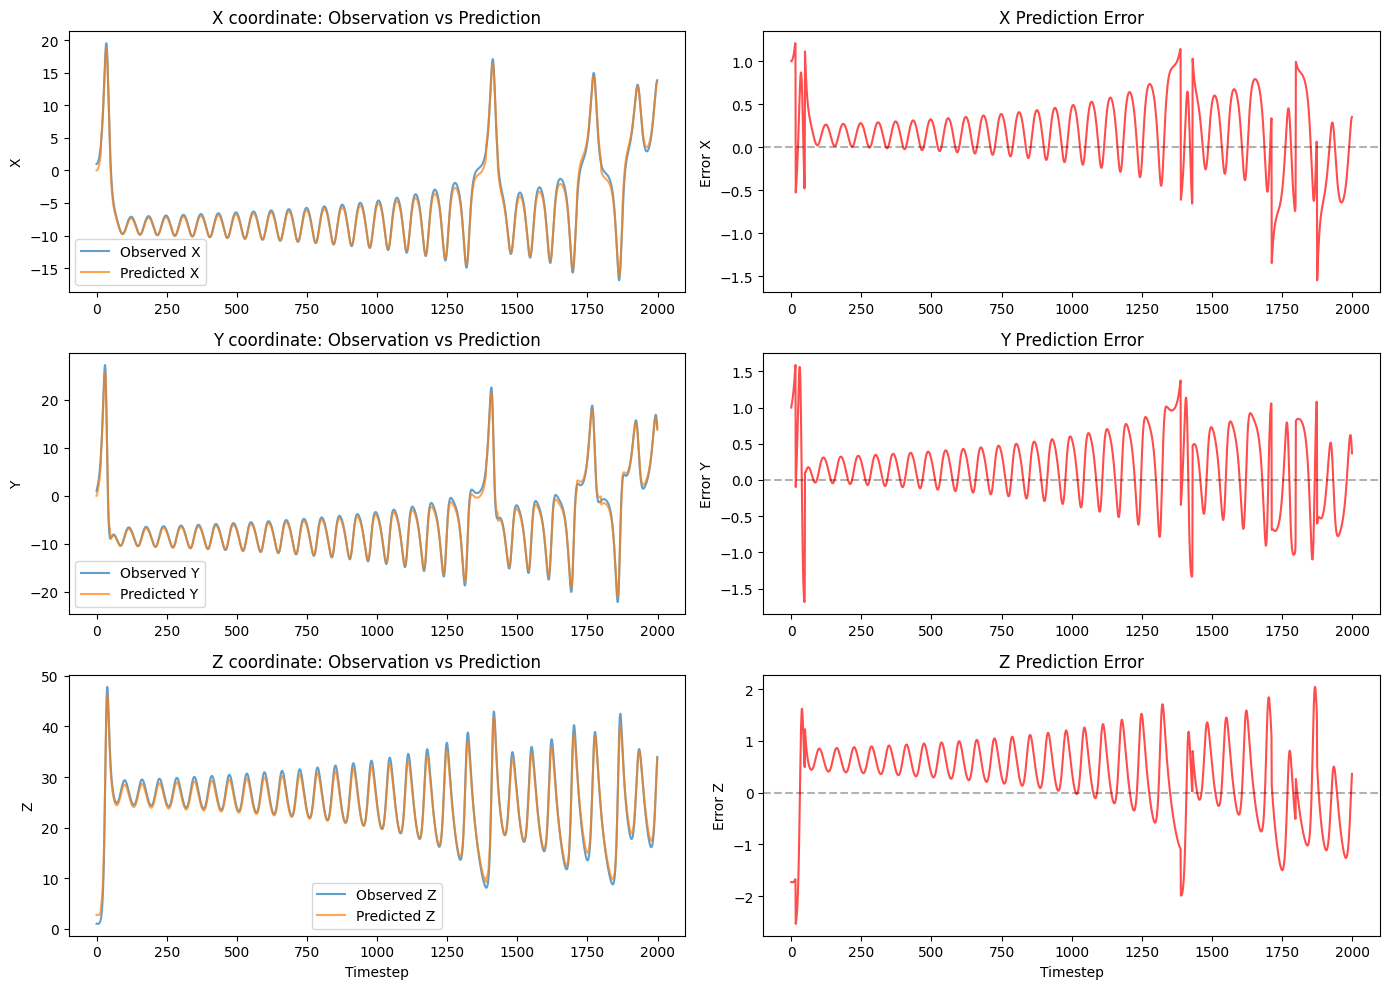

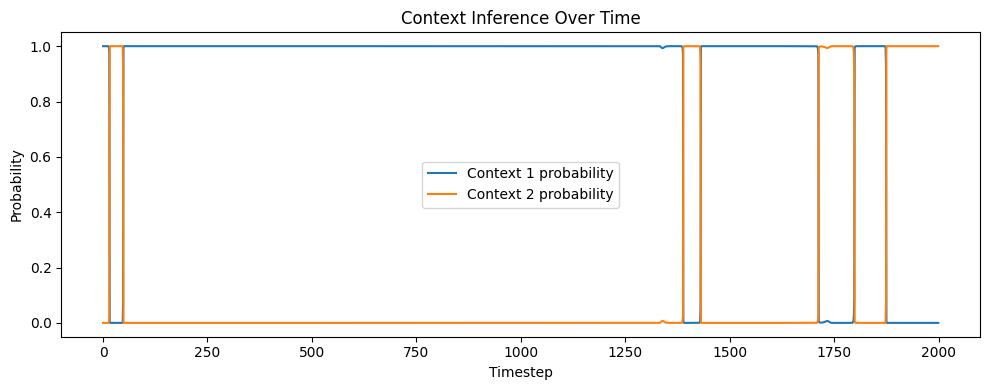

Simulation complete!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# ============== LORENZ ATTRACTOR GENERATION ==============
def lorenz_system(state, t, sigma=10, rho=40, beta=8/3):
    """Lorenz attractor differential equations"""
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

def generate_lorenz_observations(n_timesteps=500, dt=0.01):
    """Generate Lorenz attractor trajectory"""
    t = np.arange(0, n_timesteps * dt, dt)
    initial_state = [1.0, 1.0, 1.0]
    trajectory = odeint(lorenz_system, initial_state, t)
    return trajectory[:n_timesteps, :]  # (T, 3) array

# ============== PREDICTIVE CODING LAYER ==============
def gradient_ascent_predictive_coding(obs, s, mu, sigma_s, sigma_phi, z):
    """
    Predictive coding inference for continuous hidden states.
    Adapted from the dissociation model's gradient_ascent function.

    Args:
        obs: observation vector (3D for Lorenz: x, y, z)
        s: current state estimate (3D)
        mu: prior means for each context (K x 3)
        sigma_s: observation noise variance (3,)
        sigma_phi: prior variance (3,)
        z: posterior over contexts (K,)

    Returns:
        s: updated state estimate
        tau: precision (inverse variance) of estimate
    """
    diff = 11
    zsize = len(z)
    tau_s, tau_phi = 1 / sigma_s, 1 / sigma_phi
    old = np.zeros(2 * len(s))

    while np.max(np.abs(diff)) != 0.0:
        # Prediction error from observations (bottom-up)
        obs_error = (obs - s) / sigma_s

        # Prediction error from priors (top-down)
        prior_error = np.zeros_like(s)
        for k in range(zsize):
            prior_error += z[k] * (s - mu[k, :]) / sigma_phi

        # Gradient: balance bottom-up and top-down
        ds = obs_error - prior_error

        # Second derivative (precision)
        d2s = -tau_s - np.sum([z[k] * tau_phi for k in range(zsize)], axis=0)

        # Newton update
        s = s - ds / d2s
        tau = -d2s

        # Check convergence
        diff = old - np.concatenate((s, np.atleast_1d(tau).flatten()))
        diff = np.round(diff, 4)
        old = np.concatenate((s, np.atleast_1d(tau).flatten()))

    return s, tau

def Estep_z_predictive_coding(s, phi, mu, sigma_phi, tau):
    """
    Infer posterior over contexts given current state estimate.
    Adapted from Estep_z in dissociation model.
    """
    rho = np.zeros(len(phi))
    for k in range(len(phi)):
        ln_rho = np.log(phi[k]) - np.sum(((s - mu[k, :]) ** 2 + (1 / tau)) / (2 * sigma_phi))
        rho[k] = np.exp(ln_rho)
    return rho / np.sum(rho)

# ============== SIMULATION ==============
def run_predictive_coding_simulation(obs_sequence, n_contexts=2):
    """
    Run predictive coding inference over Lorenz observations.

    Args:
        obs_sequence: (T, 3) array of Lorenz coordinates
        n_contexts: number of hidden contexts (default 2 for two attractors)
    """
    T, n_channels = obs_sequence.shape

    # Initialize parameters (3 channels instead of 10)
    phi = np.array([0.5, 0.5])  # Equal prior over contexts
    sigma_s = np.full((n_channels,), 1.0)  # Observation noise
    sigma_phi = np.full((n_channels,), 10.0)  # Prior variance

    # Context-specific means (two attractor regions)
    mu = np.array([
        [-10.0, -10.0, 20.0],  # Context 1: one attractor region
        [10.0, 10.0, 30.0]     # Context 2: other attractor region
    ])

    # Storage
    states_mu = np.zeros((T, n_channels))
    states_tau = np.zeros((T, n_channels))
    context_probs = np.zeros((T, n_contexts))
    prediction_errors = np.zeros((T, n_channels))

    # Initialize state
    s = obs_sequence[0, :].copy()
    tau = 1 / sigma_s

    # Run inference at each timestep
    for t in range(T):
        old = np.full(8, 12.0)
        diff = 99

        # Iterate until convergence
        while np.max(np.abs(diff)) != 0.0:
            # E-step: infer context
            z = Estep_z_predictive_coding(s, phi.flatten(), mu, sigma_phi.flatten(), tau)

            # M-step: update state estimate
            s, tau = gradient_ascent_predictive_coding(
                obs_sequence[t, :], s, mu, sigma_s, sigma_phi, z
            )

            # Check convergence
            new = np.concatenate([s, z, np.atleast_1d(tau).flatten()])
            diff = new - old
            diff = np.round(diff, 6)
            old = new

        # Store results
        states_mu[t, :] = s
        states_tau[t, :] = tau
        context_probs[t, :] = z
        prediction_errors[t, :] = obs_sequence[t, :] - s

    return states_mu, states_tau, context_probs, prediction_errors

# ============== MAIN EXECUTION ==============
#if __name__ == "__main__":
# Generate Lorenz observations
print("Generating Lorenz attractor observations...")
obs_lorenz = generate_lorenz_observations(n_timesteps=2000, dt=0.01)

# Run predictive coding
print("Running predictive coding inference...")
states, precisions, contexts, errors = run_predictive_coding_simulation(obs_lorenz)

# Visualize results
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Plot observations vs predictions
for i, label in enumerate(['X', 'Y', 'Z']):
    axes[i, 0].plot(obs_lorenz[:, i], label=f'Observed {label}', alpha=0.7)
    axes[i, 0].plot(states[:, i], label=f'Predicted {label}', alpha=0.7)
    axes[i, 0].set_ylabel(label)
    axes[i, 0].legend()
    axes[i, 0].set_title(f'{label} coordinate: Observation vs Prediction')

# Plot prediction errors
for i, label in enumerate(['X', 'Y', 'Z']):
    axes[i, 1].plot(errors[:, i], color='red', alpha=0.7)
    axes[i, 1].set_ylabel(f'Error {label}')
    axes[i, 1].set_title(f'{label} Prediction Error')
    axes[i, 1].axhline(y=0, color='black', linestyle='--', alpha=0.3)

axes[-1, 0].set_xlabel('Timestep')
axes[-1, 1].set_xlabel('Timestep')

plt.tight_layout()
plt.show()

# Plot context inference
plt.figure(figsize=(10, 4))
plt.plot(contexts[:, 0], label='Context 1 probability')
plt.plot(contexts[:, 1], label='Context 2 probability')
plt.xlabel('Timestep')
plt.ylabel('Probability')
plt.title('Context Inference Over Time')
plt.legend()
plt.tight_layout()
plt.show()

print("Simulation complete!")

In [2]:
!pip install pillow

## Simulation with full animation

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint

# ============== LORENZ ATTRACTOR GENERATION ==============
def lorenz_system(state, t, sigma=15, rho=50, beta=8/3):
    """Lorenz attractor differential equations"""
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

def generate_lorenz_observations(n_timesteps=500, dt=0.01):
    """Generate Lorenz attractor trajectory"""
    t = np.arange(0, n_timesteps * dt, dt)
    initial_state = [1.0, 1.0, 1.0]
    trajectory = odeint(lorenz_system, initial_state, t)
    return trajectory[:n_timesteps, :]

# ============== PREDICTIVE CODING (from previous code) ==============
def gradient_ascent_predictive_coding(obs, s, mu, sigma_s, sigma_phi, z):
    """Predictive coding inference for continuous hidden states"""
    diff = 11
    zsize = len(z)
    tau_s, tau_phi = 1 / sigma_s, 1 / sigma_phi
    old = np.zeros(2 * len(s))

    while np.max(np.abs(diff)) != 0.0:
        obs_error = (obs - s) / sigma_s
        prior_error = np.zeros_like(s)
        for k in range(zsize):
            prior_error += z[k] * (s - mu[k, :]) / sigma_phi

        ds = obs_error - prior_error
        d2s = -tau_s - np.sum([z[k] * tau_phi for k in range(zsize)], axis=0)
        s = s - ds / d2s
        tau = -d2s

        diff = old - np.concatenate((s, np.atleast_1d(tau).flatten()))
        diff = np.round(diff, 4)
        old = np.concatenate((s, np.atleast_1d(tau).flatten()))

    return s, tau

def Estep_z_predictive_coding(s, phi, mu, sigma_phi, tau):
    """Infer posterior over contexts"""
    rho = np.zeros(len(phi))
    for k in range(len(phi)):
        ln_rho = np.log(phi[k]) - np.sum(((s - mu[k, :]) ** 2 + (1 / tau)) / (2 * sigma_phi))
        rho[k] = np.exp(ln_rho)
    return rho / np.sum(rho)

def run_predictive_coding_simulation(obs_sequence, n_contexts=2):
    T, n_channels = obs_sequence.shape
    phi = np.array([0.5, 0.5])
    sigma_s = np.full((n_channels,), 1.0)
    sigma_phi = np.full((n_channels,), 10.0)
    mu = np.array([[-10.0, -10.0, 20.0], [10.0, 10.0, 30.0]])

    states_mu = np.zeros((T, n_channels))
    states_tau = np.zeros((T, n_channels))
    context_probs = np.zeros((T, n_contexts))
    prediction_errors = np.zeros((T, n_channels))

    s = obs_sequence[0, :].copy()
    tau = 1 / sigma_s

    for t in range(T):
        old = np.full(8, 12.0)
        diff = 99

        while np.max(np.abs(diff)) != 0.0:
            z = Estep_z_predictive_coding(s, phi.flatten(), mu, sigma_phi.flatten(), tau)
            s, tau = gradient_ascent_predictive_coding(
                obs_sequence[t, :], s, mu, sigma_s, sigma_phi, z
            )
            new = np.concatenate([s, z, np.atleast_1d(tau).flatten()])
            diff = new - old
            diff = np.round(diff, 6)
            old = new

        states_mu[t, :] = s
        states_tau[t, :] = tau
        context_probs[t, :] = z
        prediction_errors[t, :] = obs_sequence[t, :] - s

    return states_mu, states_tau, context_probs, prediction_errors


# ============== 3D ANIMATION ==============
def create_lorenz_animation(obs_lorenz, predictions, filename='lorenz_prediction.mp4',
                           fps=30, trail_length=50):
    """
    Create 3D animation of Lorenz attractor with predictions.

    Args:
        obs_lorenz: (T, 3) array of actual Lorenz coordinates
        predictions: (T, 3) array of predicted coordinates
        filename: output video filename
        fps: frames per second
        trail_length: number of past points to show as trail
    """
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Set up the plot limits
    ax.set_xlim([obs_lorenz[:, 0].min() - 5, obs_lorenz[:, 0].max() + 5])
    ax.set_ylim([obs_lorenz[:, 1].min() - 5, obs_lorenz[:, 1].max() + 5])
    ax.set_zlim([obs_lorenz[:, 2].min() - 5, obs_lorenz[:, 2].max() + 5])

    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title('Lorenz Attractor: Actual (Red) vs Prediction (Purple)', fontsize=14)

    # Initialize line objects for trails
    line_actual, = ax.plot([], [], [], 'r-', linewidth=2, alpha=0.6, label='Actual')
    line_pred, = ax.plot([], [], [], color='purple', linewidth=2, alpha=0.6, label='Prediction')

    # Initialize scatter objects for current positions
    point_actual = ax.scatter([], [], [], c='red', s=100, marker='o', label='Actual (current)')
    point_pred = ax.scatter([], [], [], c='purple', s=100, marker='o', label='Prediction (current)')

    ax.legend(loc='upper right')

    def init():
        """Initialize animation"""
        line_actual.set_data([], [])
        line_actual.set_3d_properties([])
        line_pred.set_data([], [])
        line_pred.set_3d_properties([])
        return line_actual, line_pred, point_actual, point_pred

    def update(frame):
        """Update animation for each frame"""
        # Calculate trail start index
        start_idx = max(0, frame - trail_length)

        # Update trails
        line_actual.set_data(obs_lorenz[start_idx:frame+1, 0],
                            obs_lorenz[start_idx:frame+1, 1])
        line_actual.set_3d_properties(obs_lorenz[start_idx:frame+1, 2])

        line_pred.set_data(predictions[start_idx:frame+1, 0],
                          predictions[start_idx:frame+1, 1])
        line_pred.set_3d_properties(predictions[start_idx:frame+1, 2])

        # Update current positions
        point_actual._offsets3d = ([obs_lorenz[frame, 0]],
                                   [obs_lorenz[frame, 1]],
                                   [obs_lorenz[frame, 2]])
        point_pred._offsets3d = ([predictions[frame, 0]],
                                [predictions[frame, 1]],
                                [predictions[frame, 2]])

        # Rotate view slightly for better visualization
        ax.view_init(elev=20, azim=frame * 0.3)

        return line_actual, line_pred, point_actual, point_pred

    # Create animation
    n_frames = len(obs_lorenz)
    anim = FuncAnimation(fig, update, frames=n_frames, init_func=init,
                        blit=False, interval=1000/fps)

    # Save animation
    print(f"Saving animation to {filename}...")
    writer = FFMpegWriter(fps=fps, bitrate=1800)
    anim.save(filename, writer=writer)
    print(f"Animation saved successfully!")

    plt.close()
    return anim

from matplotlib import gridspec

def create_combined_animation(obs_lorenz, predictions, contexts, filename='lorenz_and_context.mp4', fps=30, trail_length=50, save_gif=False):
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation, FFMpegWriter
    from mpl_toolkits.mplot3d import Axes3D

    T = len(obs_lorenz)
    fig = plt.figure(figsize=(9, 10))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

    # 3D subplot
    ax3d = fig.add_subplot(gs[0], projection='3d')
    ax3d.set_xlim([obs_lorenz[:, 0].min() - 5, obs_lorenz[:, 0].max() + 5])
    ax3d.set_ylim([obs_lorenz[:, 1].min() - 5, obs_lorenz[:, 1].max() + 5])
    ax3d.set_zlim([obs_lorenz[:, 2].min() - 5, obs_lorenz[:, 2].max() + 5])
    ax3d.set_title('Lorenz Attractor: Actual (Red) vs Prediction (Purple)', pad=3)
    ax3d.set_xlabel('X')
    ax3d.set_ylabel('Y')
    ax3d.set_zlabel('Z')
    line_actual, = ax3d.plot([], [], [], 'r-', linewidth=2, alpha=0.6, label='Actual')
    line_pred, = ax3d.plot([], [], [], color='purple', linewidth=2, alpha=0.6, label='Prediction')
    point_actual = ax3d.scatter([], [], [], c='red', s=100, marker='o')
    point_pred = ax3d.scatter([], [], [], c='purple', s=100, marker='o')
    ax3d.legend(loc='upper right', bbox_to_anchor=(0.98,0.93))

    # 2D subplot (context inference)
    axctx = fig.add_subplot(gs[1])
    axctx.set_xlim(0, T)
    axctx.set_ylim(0, 1.1)  # Increased upper limit
    axctx.set_yticks(np.arange(0, 1.1, 0.1))  # Ticks: 0.0, 0.1, ..., 1.0 (not 1.1)
    axctx.set_xlabel('Timestep')
    axctx.set_ylabel('Probability')
    axctx.set_title('Context Inference Over Time')
    ctx_line1, = axctx.plot([], [], label='Context 1 probability', color='blue', linewidth=3)
    ctx_line2, = axctx.plot([], [], label='Context 2 probability', color='orange', linewidth=3)
    axctx.legend()

    plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.98, hspace=0.1)


    def init():
        line_actual.set_data([], [])
        line_actual.set_3d_properties([])
        line_pred.set_data([], [])
        line_pred.set_3d_properties([])
        ctx_line1.set_data([], [])
        ctx_line2.set_data([], [])
        return line_actual, line_pred, point_actual, point_pred, ctx_line1, ctx_line2

    def update(frame):
        start_idx = max(0, frame - trail_length)
        # 3D trails
        line_actual.set_data(obs_lorenz[start_idx:frame + 1, 0], obs_lorenz[start_idx:frame + 1, 1])
        line_actual.set_3d_properties(obs_lorenz[start_idx:frame + 1, 2])
        line_pred.set_data(predictions[start_idx:frame + 1, 0], predictions[start_idx:frame + 1, 1])
        line_pred.set_3d_properties(predictions[start_idx:frame + 1, 2])
        point_actual._offsets3d = ([obs_lorenz[frame, 0]], [obs_lorenz[frame, 1]], [obs_lorenz[frame, 2]])
        point_pred._offsets3d = ([predictions[frame, 0]], [predictions[frame, 1]], [predictions[frame, 2]])
        ax3d.view_init(elev=20, azim=frame * 0.3)
        # 2D context
        ctx_line1.set_data(np.arange(frame + 1), contexts[:frame + 1, 0])
        ctx_line2.set_data(np.arange(frame + 1), contexts[:frame + 1, 1])
        return line_actual, line_pred, point_actual, point_pred, ctx_line1, ctx_line2

    anim = FuncAnimation(fig, update, frames=T, init_func=init, blit=False, interval=1000 / fps)
    print(f"Saving animation to {filename}...")
    writer = FFMpegWriter(fps=fps, bitrate=1800)
    anim.save(filename, writer=writer)
    print(f"Animation saved successfully!")


    if save_gif:
      # Save GIF
      from matplotlib.animation import PillowWriter
      gif_filename = filename.replace('.mp4', '.gif')
      gif_writer = PillowWriter(fps=fps)
      anim.save(gif_filename, writer=gif_writer)
      print(f"GIF animation saved successfully as {gif_filename}!")

    plt.close()
    return anim
# ============== MAIN EXECUTION ==============
# if __name__ == "__main__":
# Generate Lorenz observations
print("Generating Lorenz attractor observations...")
obs_lorenz = generate_lorenz_observations(n_timesteps=120, dt=0.01)   # n_timesteps=500

# Run predictive coding
print("Running predictive coding inference...")
states, precisions, contexts, errors = run_predictive_coding_simulation(obs_lorenz)

# # Create 3D animation
# print("Creating 3D animation...")
# anim = create_lorenz_animation(
#     obs_lorenz,
#     predictions,
#     filename='lorenz_prediction_3d.mp4',
#     fps=30,
#     trail_length=50
# )
# print("Complete! Video saved as 'lorenz_prediction_3d.mp4'")

#create_combined_animation(obs_lorenz, states, contexts, filename='lorenz_and_context.mp4')
create_combined_animation(obs_lorenz, states, contexts, filename='lorenz_and_context.mp4', save_gif=True)



print("Complete! Video saved as 'lorenz_and_context.mp4'")

Generating Lorenz attractor observations...
Running predictive coding inference...
Saving animation to lorenz_and_context.mp4...
Animation saved successfully!
GIF animation saved successfully as lorenz_and_context.gif!
Complete! Video saved as 'lorenz_and_context.mp4'
